# Motif and Substructure Discovery with ESM-2 and Persistent Homology

In [1]:
# Let's start by importing necessary libraries
from transformers import EsmModel, AutoTokenizer
import gudhi as gd
import numpy as np
import torch
from scipy.spatial.distance import pdist, jensenshannon, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from gudhi.hera import wasserstein_distance

In [2]:
text = ["MAVESRVTQEEIKKEPEKPIDREKTCPLLLRVFTTNNGRHHRMDEFSRGNVPSSELQIYTWMDATLKELTSLVKEVYPEARKKGTHFNFAIVFTDVKRPGYRVKEIGSTMSGRKGTDDSMTLQSQKFQIGDYLDIAITPPNRAPPPSGRMRPY"]

In [3]:
import torch

def compute_output(sentence, layer, head):
    # Load pre-trained model
    tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
    model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D", output_attentions=True)

    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    # Specify `output_hidden_states=True` when calling the model
    outputs = model(**inputs, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O


In [4]:
# Set the layer and head to use for computation
layer = 3
head = 2

# Compute the context vectors for each text in the corpus
context = [compute_output(t, layer, head) for t in text]
print(context[0].shape)
print(context[0])

Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([1, 155, 16])
tensor([[[ 0.6743,  0.5545,  1.2208,  ...,  0.0626, -0.9014, -0.7621],
         [ 0.6362,  0.4581,  1.1848,  ...,  0.0766, -0.9643, -0.7803],
         [ 0.6222,  0.4346,  1.1726,  ...,  0.0467, -0.9650, -0.7802],
         ...,
         [ 0.7480,  0.3212,  0.9947,  ..., -0.2329, -0.6257, -0.7537],
         [ 0.7485,  0.3842,  1.0374,  ..., -0.2265, -0.6053, -0.7752],
         [ 0.6429,  0.5328,  1.0885,  ..., -0.3019, -0.6538, -0.7992]]],
       grad_fn=<CloneBackward0>)


Barcode for text 0:


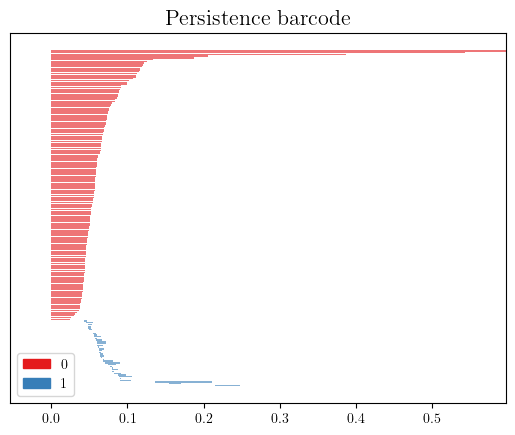

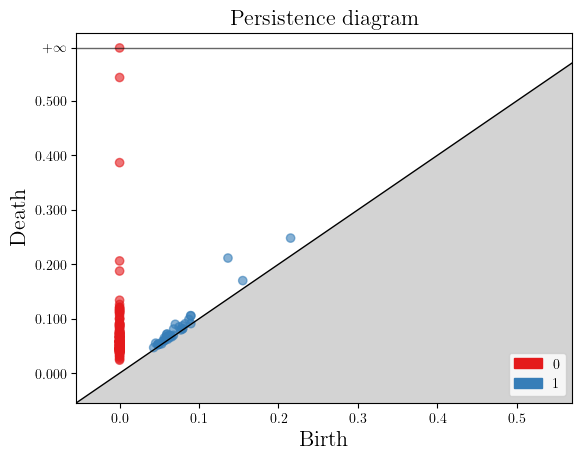

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix
import gudhi as gd

def compute_distances_and_plot_barcode(output):
    # Detach the output tensor, squeeze, and convert to numpy array
    output_np = output.squeeze().detach().numpy()

    # Compute the pairwise Euclidean distance matrix
    distances = distance_matrix(output_np, output_np)

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)
    
    # Plot the barcode diagram
    gd.plot_persistence_barcode(persistence=persistent_homology)
    gd.plot_persistence_diagram(persistence=persistent_homology)

    plt.show()

# Compute the barcode diagrams for each context vector
for i, output in enumerate(context):
    print(f"Barcode for text {i}:")
    compute_distances_and_plot_barcode(output)

In [6]:
def cluster_and_get_positions(context, sentence, eps):
    # Load pre-trained model tokenizer
    tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")

    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Squeeze the context tensor to remove the batch size dimension
    context = context.squeeze(0)

    # Compute the pairwise distance matrix
    distances = pdist(context.detach().numpy(), 'euclidean')
    dist_matrix = squareform(distances)

    # Run DBSCAN on the distance matrix
    clustering = DBSCAN(eps=eps, min_samples=2, metric='precomputed').fit(dist_matrix)

    # Get the words corresponding to each cluster
    clusters = {}
    for i, label in enumerate(clustering.labels_):
        if label != -1:  # Ignore noise (-1 label)
            if label not in clusters:
                clusters[label] = []
            clusters[label].append((tokens[i], i))  # Store both the token and its position

    return clusters

# Compute the clusters for each context vector
clusters = []
for i, output in enumerate(context):
    print(f"Clusters for text {i}:")
    clusters.append(cluster_and_get_positions(output, text[i], 0.05))
    for label, words in clusters[-1].items():
        print(f"Cluster {label}: {', '.join(word for word, _ in words)}")

# Assuming you want to get the positions of the tokens in the first cluster of the first text:
cluster_number = 7  # Change this to the desired cluster number
text_number = 0  # Change this to the desired text number

cluster_positions = [position for _, position in clusters[text_number][cluster_number]]
print(f"Positions of the tokens in cluster {cluster_number} of text {text_number}: {cluster_positions}")


Clusters for text 0:
Cluster 0: E, S
Cluster 1: I, P
Cluster 2: K, K
Cluster 3: F, R, N
Cluster 4: T, N
Cluster 5: G, R, Q
Cluster 6: R, M, V, A
Cluster 7: E, E, L, Y, D, K, L, E, A
Cluster 8: G, W, M, L
Cluster 9: I, S, K, V
Cluster 10: E, L, T
Cluster 11: R, K
Cluster 12: F, A, V, F, T, D, V, R, G, R, K, E, T, M, S, G, R, G, Q, I
Cluster 13: F, V, G
Cluster 14: T, L, K, Q, I
Cluster 15: A, M
Positions of the tokens in cluster 7 of text 0: [45, 55, 56, 59, 63, 67, 72, 75, 80]


In [7]:
import torch
import numpy as np
from scipy.spatial import distance_matrix
from transformers import AutoTokenizer, EsmModel
from umap.umap_ import UMAP
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")

def compute_output(sentence, layer, head):
    # Load pre-trained model
    global tokenizer
    model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

    # Set the output_attentions attribute of the configuration to True
    model.config.output_attentions = True

    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    outputs = model(**inputs, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O, inputs

# Compute the output
output, inputs = compute_output("MAVESRVTQEEIKKEPEKPIDREKTCPLLLRVFTTNNGRHHRMDEFSRGNVPSSELQIYTWMDATLKELTSLVKEVYPEARKKGTHFNFAIVFTDVKRPGYRVKEIGSTMSGRKGTDDSMTLQSQKFQIGDYLDIAITPPNRAPPPSGRMRPY", 3, 2)

# Convert the output tensor to numpy array
output_np = output.detach().numpy()[0]

# Compute the pairwise Euclidean distance matrix
distances = distance_matrix(output_np, output_np)

# Compute the number of tokens
num_tokens = len(inputs["input_ids"][0])

# Decompose output to 3D for visualization using UMAP
umap = UMAP(n_components=3)  # Set n_components to 3
output_3d = umap.fit_transform(output_np)

# Define the function to update the plot
def update_plot(eps):
    # Create a plotly graph object
    fig = go.Figure()

    # Get token labels
    token_labels = [tokenizer.decode([token_id]) for token_id in inputs['input_ids'][0]]
    
    # Set the colors for the tokens
    subset_positions = [45, 55, 56, 59, 63, 67, 72, 75, 80]
    colors = ['red' if i in subset_positions else 'blue' for i in range(len(token_labels))]

    # Add 3D scatter plot points
    fig.add_trace(go.Scatter3d(x=output_3d[:, 0], y=output_3d[:, 1], z=output_3d[:, 2],
                    mode='markers+text',   # Added 'text' to 'mode' to show the token labels
                    text=token_labels,     # Specify the text(labels) to be displayed
                    textposition='top center',   # Position the text to be top center wrt the marker
                    marker=dict(
                        size=6,
                        color=colors,   # Specify the colors for the markers
                        opacity=0.8
                    ),
                    hovertemplate = "%{text}<br>x: %{x}<br>y: %{y}<br>z: %{z}<extra></extra>",
    ))

    # Add edges
    for i in range(distances.shape[0]):
        for j in range(i+1, distances.shape[1]):
            if distances[i, j] <= eps:
                fig.add_trace(go.Scatter3d(x=[output_3d[i, 0], output_3d[j, 0]],
                                        y=[output_3d[i, 1], output_3d[j, 1]], 
                                        z=[output_3d[i, 2], output_3d[j, 2]],
                                        mode='lines',
                                        line=dict(
                                            color='darkblue',
                                            width=2
                                        )))

    fig.update_layout(scene = dict(
                    xaxis_title='X AXIS',
                    yaxis_title='Y AXIS',
                    zaxis_title='Z AXIS'),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))
    fig.show()



# Create the interactive widget for the threshold distance parameter
eps_slider = FloatSlider(min=0, max=np.max(distances), step=0.01, value=0, description='eps:')
interact(update_plot, eps=eps_slider)


/Users/amelieschreiber/anaconda3/envs/env_1/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/amelieschreiber/anaconda3/envs/env_1/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/amelieschreiber/anaconda3/envs/env_1/lib/pyth

interactive(children=(FloatSlider(value=0.0, description='eps:', max=1.6711198494853368, step=0.01), Output())…

<function __main__.update_plot(eps)>